In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn import set_config
set_config(display="diagram")
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_auc_score,plot_confusion_matrix

# Reading and Changing the Label to Numberic

In [2]:
df = pd.read_csv('Data/raw_clean_data.csv')

In [3]:
df.head()

,text,rating,Label
0,beautiful accomodations stayed hotel santa mar...,4,Positive
1,great hotel great location hotel located la ra...,5,Positive
2,beautiful hotel great location like beautifull...,4,Positive
3,great deal waikiki trip hawaii outrigger luana...,4,Positive
4,choose airport hotel busy triparound australia...,1,Negative


In [4]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [5]:
df.head()

,text,rating,Label
0,beautiful accomodations stayed hotel santa mar...,4,1
1,great hotel great location hotel located la ra...,5,1
2,beautiful hotel great location like beautifull...,4,1
3,great deal waikiki trip hawaii outrigger luana...,4,1
4,choose airport hotel busy triparound australia...,1,0


# NLP

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [7]:
X = df['text']
y = df['Label']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

proc = TextPreprocessor()

# again this kind of splitting only becomes important if fitting of text transformers fits to statistics of the text corpus
transformed_train = proc.fit_transform(X_train) 
transformed_test = proc.transform(X_test)


In [9]:
transformed_train[925]

'disappointing experience stay oriente reccommended travel agent rat star hotel becuase cost room think clean comfortable arrive hotel renovate drilling started thing morning hear breakfast room awful picture use hotel extremely misleading room tiny big double bed grime wall bathroom size cupboard stay star hotel half price standard high advice consider hotel location fine long mind pay odds room cheap student hostel good thing say oriente staff pleasant'

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
prc_steps = [
    ('tfidf', TfidfVectorizer(min_df = 0.05, max_df = 0.95)), 
            ('combnb', ComplementNB())]
pipeline = Pipeline(prc_steps)

In [12]:
pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('combnb', ComplementNB())])

In [13]:
pipeline.fit(transformed_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('combnb', ComplementNB())])

In [14]:
# automatically applies transforms and predicts on test
y_pred = pipeline.predict(transformed_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      1607
           1       0.92      0.80      0.86      4541

    accuracy                           0.80      6148
   macro avg       0.75      0.80      0.77      6148
weighted avg       0.83      0.80      0.81      6148



In [16]:
roc_auc_score(y_test, y_pred)

0.800333324791463

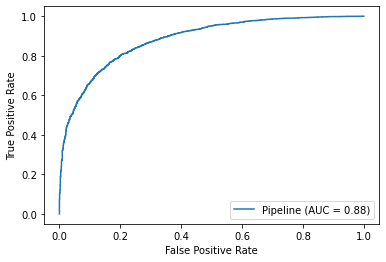

In [17]:
plot_roc_curve(pipeline, transformed_test, y_test)

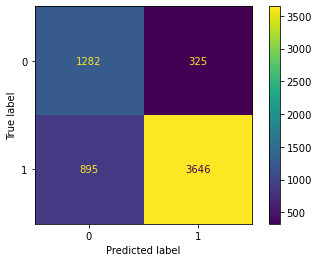

In [18]:
plot_confusion_matrix(pipeline, transformed_test, y_test)